# Face Detection Using CNN Algorithms

>**This project is for building CNN architecture for facial features and face detection by plotting points on the facial features and box around the face**

In [1]:
# import packages
import PIL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing import image

%matplotlib inline

## 1. Data Wrangling

### 1.1. Data Loading

>  
**Data Source:** https://www.kaggle.com/jessicali9530/celeba-dataset  
But we are going to **use only the data of the first 35000 images** as a start then we are going to update the model step by step beacuse the data is very very big **(1 GB)**

In [2]:
# This cell for the values that will be used across the entire notebook
# pathes
key_points_data_path = "./data/list_landmarks_align_celeba.csv"
images_data_path = "./data/images"

# data size
images_data_size = 35000

# originsl image dimensions
x_org = 178    # original x value
y_org = 218    # original y value

# new image dimensions
x_ = 45                             # new value of x
image_size_ratio = x_org / y_org    # dimensions ratio
y_ = int(image_size_ratio * x_)     # new value of y

# image sizes
original_image_size = (x_org, y_org)
new_image_size = (x_,y_)

# the image size that will be used in the training process
image_size_training = new_image_size

# check the new size value
new_image_size

(45, 36)

#### 1.1.1. Key points data

In [3]:
# load the dataset (key points)
df_org = pd.read_csv(key_points_data_path)
df_org = df_org[:images_data_size]

# check
df_org.head(3)

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158


In [4]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_id      35000 non-null  object
 1   lefteye_x     35000 non-null  int64 
 2   lefteye_y     35000 non-null  int64 
 3   righteye_x    35000 non-null  int64 
 4   righteye_y    35000 non-null  int64 
 5   nose_x        35000 non-null  int64 
 6   nose_y        35000 non-null  int64 
 7   leftmouth_x   35000 non-null  int64 
 8   leftmouth_y   35000 non-null  int64 
 9   rightmouth_x  35000 non-null  int64 
 10  rightmouth_y  35000 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 2.9+ MB


#### 1.1.2. Images Data

In [5]:
# convert images to arrays to use it in training
images_data = list()
for idx in range(df_org.shape[0]):
    # to get the path based on index
    path = "{}/{}".format(str(images_data_path),str(df_org.iloc[idx].image_id))
    
    # to read the image
    image = PIL.Image.open(path).resize(image_size_training)
    image_array = np.asarray(image) / 255
    
    # append the image array to images_data
    images_data.append(image_array)
    
# convert images_data to be array not list
images_data = np.array(images_data)

# check
images_data.shape

(35000, 36, 45, 3)

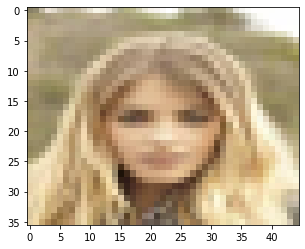

In [6]:
# test
plt.imshow(images_data[18]);

In [7]:
# Final data sets which we will work with
print("Images Data Arrays Shape:", images_data.shape)
print("Key Points Data Shape:", df_org.shape)

Images Data Arrays Shape: (35000, 36, 45, 3)
Key Points Data Shape: (35000, 11)


### 1.2. Data Cleaning (Preprocessing)

In [8]:
# check if there is any null values in the data
df_org.isnull().sum()

image_id        0
lefteye_x       0
lefteye_y       0
righteye_x      0
righteye_y      0
nose_x          0
nose_y          0
leftmouth_x     0
leftmouth_y     0
rightmouth_x    0
rightmouth_y    0
dtype: int64

In [9]:
# check the numerical values properties in the data
df_org.describe()

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
count,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000
mean,69.368743,111.189143,107.625971,111.153229,88.030029,135.075829,71.282286,152.119200,105.553571,152.215571
std,1.717107,1.128984,1.685886,1.178651,6.702350,4.264796,3.171467,1.795088,3.241235,1.736808
min,60.000000,99.000000,90.000000,99.000000,59.000000,102.000000,60.000000,142.000000,90.000000,139.000000
25%,68.000000,111.000000,107.000000,111.000000,84.000000,133.000000,69.000000,151.000000,103.000000,151.000000
50%,69.000000,111.000000,108.000000,111.000000,88.000000,135.000000,72.000000,152.000000,105.000000,152.000000
75%,70.000000,112.000000,109.000000,112.000000,92.000000,138.000000,74.000000,153.000000,108.000000,153.000000
max,85.000000,121.000000,121.000000,120.000000,120.000000,154.000000,88.000000,168.000000,119.000000,170.000000


> **Data is clean and ready for analysis**

### 1.3. Images reading and plotting

In [10]:
# function to read images based on index
def image_array(index, size=image_size_training, path=images_data_path):
    """
    This functions is for converting images to arrays to deal with it in the model.
    
    Input:  index of the image that we want to convert to array
            size of the image that we want for the array of the image
            path of the images data to get the image
            
    Output: the image array as numpy array
    """
    # to get the path based on index
    path = "{}/{}".format(str(path),str(df_org.iloc[index].image_id))
    
    # to read the image
    image = PIL.Image.open(path).resize(size)
    image_array = np.asarray(image)
    
    return image_array

In [11]:
# function to get a list of all key points of the face
def image_key_points_list(index, df = df_org):
    """
    This function for getting the key points on the face as list to deal with it in plotting sections
    """
    # box dictionary
    points_list = [df.iloc[index].lefteye_x,
                   df.iloc[index].lefteye_y,
                   df.iloc[index].righteye_x,
                   df.iloc[index].righteye_y,
                   df.iloc[index].nose_x,
                   df.iloc[index].nose_y,
                   df.iloc[index].leftmouth_x,
                   df.iloc[index].leftmouth_y,
                   df.iloc[index].rightmouth_x,
                   df.iloc[index].rightmouth_y]
    
    return points_list

In [12]:
# function to plot the image with green box around the faces
def plotting_image_with_box(index, df = df_org, size=original_image_size):
    """
    This function for plotting the image with points on facial features and box around the face
    """
    test_image = image_array(index, size)
    points_list = image_key_points_list(index, df)
    
    # face points
    le_x, le_y, re_x, re_y = points_list[0], points_list[1], points_list[2], points_list[3]
    n_x, n_y = points_list[4], points_list[5]
    lm_x, lm_y, rm_x, rm_y = points_list[6], points_list[7], points_list[8], points_list[9]
    
    # Create figure and axes
    fig, ax = plt.subplots()
    # plot the image
    ax.imshow(test_image)
    # plot the points on the face
    ax.plot([le_x,re_x,n_x,lm_x,rm_x], [le_y,re_y,n_y,lm_y,rm_y], 'bo-')
    
    # plot the box around the face
    width = abs(le_x-rm_x-60)
    height = abs(le_y-rm_y-75)
    rect = patches.Rectangle((le_x-30, le_y-40), width, height, linewidth=4, edgecolor='g', facecolor='none')
    ax.add_patch(rect);

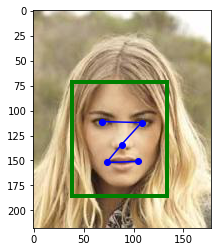

In [13]:
# test
index = 18
plotting_image_with_box(index)

## 2. Preparing the data for ML model

### 2.1. Rescaling key points to be consistent with the new image size for training

In [14]:
# copy a version from the data to prepare it for analysis
df = df_org.copy()

# check
df.head(3)

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158


In [15]:
# function for updating key points for a new size
def rescale_key_points(oldsize=original_image_size, newsize=image_size_training):
    """
    This function is for rescaling the key points from the original scale to a nwe scale from our chossen and we reduce
    the image size to make the analysis faster and using lower memory
    """
    # old and nwe sizes (x,y) values
    x_axis_old = oldsize[0]
    y_axis_old = oldsize[1]

    x_axis_new = newsize[0]
    y_axis_new = newsize[1]

    x_ratio = x_axis_new / x_axis_old
    y_ratio = y_axis_new / y_axis_old
    
    # converting the keypoints values to be trained with the new size of the images
    keypoints_x = ['lefteye_x', 'righteye_x', 'nose_x', 'leftmouth_x', 'rightmouth_x']
    keypoints_y = ['lefteye_y', 'righteye_y', 'nose_y', 'leftmouth_y', 'rightmouth_y']
    
    df[keypoints_x] = (df[keypoints_x] * x_ratio).astype('int')
    df[keypoints_y] = (df[keypoints_y] * y_ratio).astype('int')
    
    return 0

# call the function
rescale_key_points()

# check
df.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,17,18,26,18,19,23,18,25,27,25
1,000002.jpg,17,18,27,18,20,22,17,24,27,25
2,000003.jpg,19,18,26,17,27,21,18,25,24,26
3,000004.jpg,18,18,27,17,25,22,17,25,25,24
4,000005.jpg,16,18,28,18,21,19,17,24,26,24


### 2.2. Split the data into training and test datasets

In [16]:
# training data
train_labels = df[:images_data_size - 1000]
train_images = images_data[:images_data_size - 1000]


# test data (1000 sample)
test_labels = df[images_data_size - 1000 + 1:]
test_images = images_data[images_data_size - 1000 + 1:]

## 2.3 Split the data into train and validation datasets

In [17]:
# droping image_id column as we will not use it in the model
y = train_labels.drop(['image_id'], axis = 1)      # labels
X = train_images                                   # images

# check
y.head(2)

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,17,18,26,18,19,23,18,25,27,25
1,17,18,27,18,20,22,17,24,27,25


In [18]:
# to split the data into two sets (one for training and one for testing)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.17,random_state = 42)

# check the ratio
X_val.shape[0]/X_train.shape[0]

0.20481927710843373

## 3. Building and training the model

In [19]:
# diminsions of the image in the traing process
x_ = image_size_training[0]
y_ = image_size_training[1]

# build the model
model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation="relu", input_shape=(y_,x_,3)))
model.add(Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='relu'))

In [20]:
# get the summary of the model layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 36, 45, 8)         224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 45, 8)         584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 22, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 22, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 22, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 22, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 11, 16)         0

In [21]:
# compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [22]:
# fitting the model with our data
training_process = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val), batch_size=300, shuffle=True)

Epoch 1/200
95/95 [==============================] - 36s 364ms/step - loss: 356.3032 - accuracy: 0.0212 - val_loss: 136.6288 - val_accuracy: 0.0839
Epoch 2/200
95/95 [==============================] - 34s 354ms/step - loss: 96.4360 - accuracy: 0.2974 - val_loss: 56.0193 - val_accuracy: 0.9016
Epoch 3/200
95/95 [==============================] - 33s 351ms/step - loss: 48.4067 - accuracy: 0.3325 - val_loss: 51.7976 - val_accuracy: 0.9016
Epoch 4/200
95/95 [==============================] - 33s 353ms/step - loss: 39.2384 - accuracy: 0.3253 - val_loss: 29.4488 - val_accuracy: 0.9016
Epoch 5/200
95/95 [==============================] - 33s 351ms/step - loss: 33.1063 - accuracy: 0.3118 - val_loss: 26.8645 - val_accuracy: 0.9016
Epoch 6/200
95/95 [==============================] - 33s 352ms/step - loss: 30.0982 - accuracy: 0.3284 - val_loss: 34.5306 - val_accuracy: 0.9016
Epoch 7/200
95/95 [==============================] - 34s 357ms/step - loss: 26.4453 - accuracy: 0.3643 - val_loss: 27.1177

## 4. Test the model

In [23]:
def predictions_test_model(index):
    img = tf.keras.preprocessing.image.load_img("{}/0{}.jpg".format(images_data_path, index),target_size=(y_,x_,3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    points_list = model.predict(img.reshape(1,y_,x_,3)).astype('int')[0]
    
    # converting key points values to the original size
    x_ratio = 1.05 * (original_image_size[0] / image_size_training[0])
    y_ratio = 1.085 * (original_image_size[1] / image_size_training[1])
    """
    In the previous ratios we multiply them by contant to reduce the noise that happened when we rescaled the points in
    the previous training, there is no meaning for these numbers (i just pick them with trails)
    """
    
    points_list[0] = int(points_list[0] * x_ratio)
    points_list[2] = int(points_list[2] * x_ratio)
    points_list[4] = int(points_list[4] * x_ratio)
    points_list[6] = int(points_list[6] * x_ratio)
    points_list[8] = int(points_list[8] * x_ratio)
    
    points_list[1] = int(points_list[1] * y_ratio)
    points_list[3] = int(points_list[3] * y_ratio)
    points_list[5] = int(points_list[5] * y_ratio)
    points_list[7] = int(points_list[7] * y_ratio)
    points_list[9] = int(points_list[9] * y_ratio)
    
    return points_list

In [24]:
# function to plot the image with green box around the faces
def test_image_with_box_plot(index, pred_or_actual = 'pred', pointsColor='bo-' ,boxcolor='g'):
    img = tf.keras.preprocessing.image.load_img("{}/0{}.jpg".format(images_data_path, index),target_size=(y_org,x_org,3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    test_image = img/255
    
    # predictions of key points on the face
    if pred_or_actual == 'pred':
        points_list = predictions_test_model(index)        # this for predections of the model
    elif pred_or_actual == 'actual':
        points_list = image_key_points_list(index)   # this for the actual labels of the test data
    
    # face points
    le_x, le_y, re_x, re_y = points_list[0], points_list[1], points_list[2], points_list[3]
    n_x, n_y = points_list[4], points_list[5]
    lm_x, lm_y, rm_x, rm_y = points_list[6], points_list[7], points_list[8], points_list[9]

    # Create figure and axes
    fig, ax = plt.subplots()
    # plot the image
    ax.imshow(test_image)
    # plot the points on the face
    ax.plot([le_x,re_x,n_x,lm_x,rm_x], [le_y,re_y,n_y,lm_y,rm_y], pointsColor)
    
    # plot the box around the face
    width = abs(le_x-rm_x-60)
    height = abs(le_y-rm_y-75)
    rect = patches.Rectangle((le_x-30, le_y-40), width, height, linewidth=4, edgecolor=boxcolor, facecolor='none')
    ax.add_patch(rect);
    return points_list

RED box for predections

GREEN box for actual labels



[69, 111, 108, 112, 87, 139, 72, 151, 105, 153]

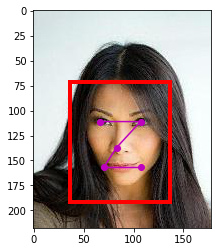

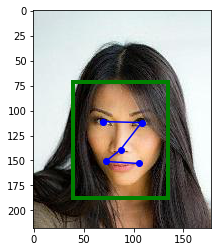

In [29]:
# test the model performace
index = 34100
print('RED box for predections\n') 
print('GREEN box for actual labels\n')
test_image_with_box_plot(index, pred_or_actual = 'pred', pointsColor='mo-' ,boxcolor='r')
test_image_with_box_plot(index, pred_or_actual = 'actual')

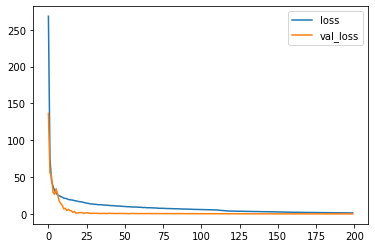

In [30]:
# losses of both training and validation sets
loss = training_process.history['loss']
val_loss = training_process.history['val_loss']

# plot both losses
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss']);

In [34]:
# accuracy of the model
accuracy = model.evaluate(X_val,y_val)[1] * 100
print("Accuracy of the model = ", round(accuracy,2))

181/181 [==============================] - 3s 16ms/step - loss: 0.3970 - accuracy: 0.9016
Accuracy of the model =  90.16


## 5. Save the model

In [35]:
# saving the model as h5 file
model.save('model.h5')